In [1]:
import numpy as np
import cv2 
import re
from PIL import Image
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/home/user/data/twins_aligned_cropped_resized'

In [2]:
from transforms import get_transform_base, get_transform_kp, std, mean

# define crop transform of your choice
size = 512

# center crop + normalize
transform_base = get_transform_base(size)

# same as above + support for keypoints
transform_kp = get_transform_kp(size)

In [3]:
# front images for each id
views = pd.read_csv(os.path.join(ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv(os.path.join(ROOT, 'df', 'pairs.csv'))

In [4]:
print(views.shape)
views.head()

(435, 3)


,filename,subject_id,label
person_id,,,
90003,"[90003d17.jpg, 90003d18.jpg, 90003d40.jpg, 900...",90003,0
90004,"[90004d17.jpg, 90004d18.jpg, 90004d40.jpg, 900...",90004,1
90005,"[90005d17.jpg, 90005d18.jpg, 90005d40.jpg, 900...",90005,2
90006,"[90006d14.jpg, 90006d15.jpg, 90006d37.jpg, 900...",90006,3
90007,"[90007d17.jpg, 90007d18.jpg, 90007d36.jpg, 900...",90007,4


In [5]:
print(pairs.shape)
pairs.head()

(854, 3)


,id_1,id_2,label
0,90308,90308,Same
1,90404,90404,Same
2,90062,90062,Same
3,90052,90052,Same
4,90144,90144,Same


### For siamese classification & similarity learning

In [6]:
from dataset import TwinPairsDataset

In [7]:
pairs_dataset = TwinPairsDataset(ROOT, pairs, views, transform=transform_kp, keypoints=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


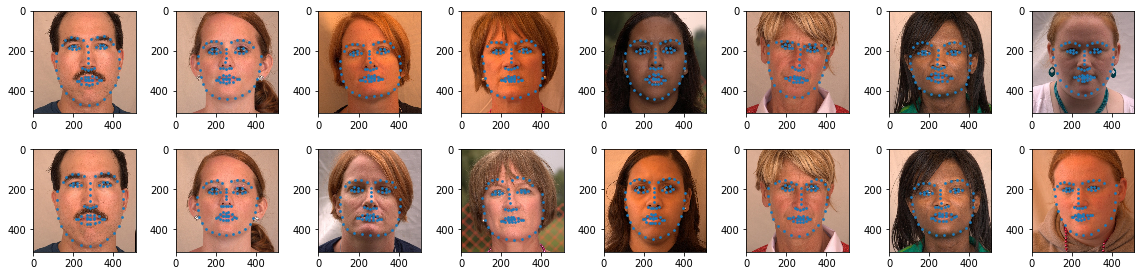

In [8]:
n_show = 8
fig, axs = plt.subplots(2, n_show, figsize=(16, 4))
for idx in range(n_show):
    sample = pairs_dataset[idx]
    
    axs[0, idx].imshow(sample['image1'].numpy().transpose(1,2,0)*std + mean)    
    axs[0, idx].scatter(sample['keypoints1'][:,0], sample['keypoints1'][:,1], s=3)
    
    axs[1, idx].imshow(sample['image0'].numpy().transpose(1,2,0)*std + mean)    
    axs[1, idx].scatter(sample['keypoints0'][:,0], sample['keypoints0'][:,1], s=3)
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


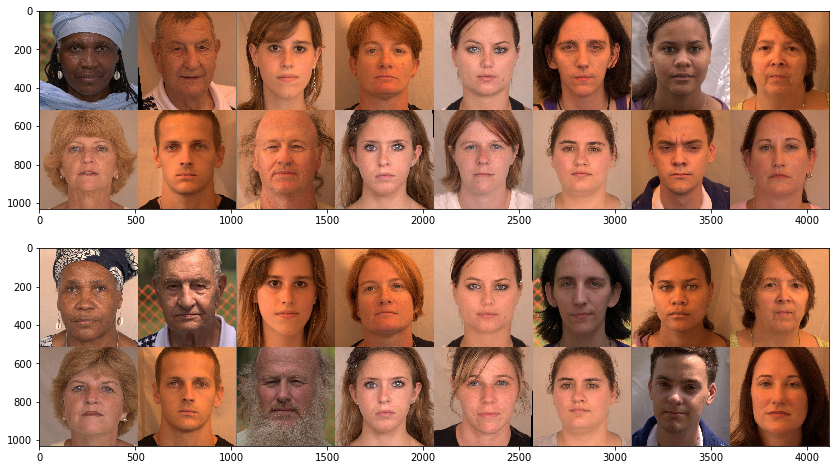

In [9]:
pairs_dataset = TwinPairsDataset(ROOT, pairs, views, transform=transform_base, keypoints=False)
# pairs_dataset = TwinPairsDataset(ROOT, pairs, views, transform=transform_kp, keypoints=True)
pairs_loader = DataLoader(pairs_dataset, batch_size=16, shuffle=True)

batch = next(iter(pairs_loader))
grid_1 = make_grid(batch['image1'])
grid_2 = make_grid(batch['image0'])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

axs[0].imshow(grid_1.numpy().transpose(1,2,0)*std + mean)
axs[1].imshow(grid_2.numpy().transpose(1,2,0)*std + mean)

### Classification datatset for arcface/cosface

In [10]:
from dataset import ClassificationDataset

In [11]:
clf_dataset = ClassificationDataset(ROOT, views, transform=transform_kp, keypoints=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


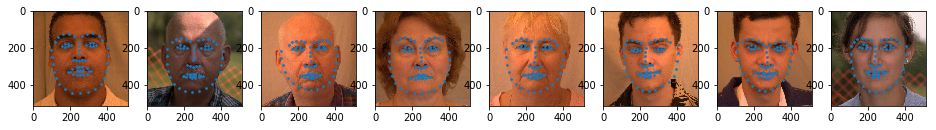

In [12]:
n_show = 8
fig, axs = plt.subplots(1, n_show, figsize=(16, 4))
for idx in range(n_show):
    sample = clf_dataset[idx]
    axs[idx].imshow(sample['image'].numpy().transpose(1,2,0)*std + mean)    
    axs[idx].scatter(sample['keypoints'][:,0], sample['keypoints'][:,1], s=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


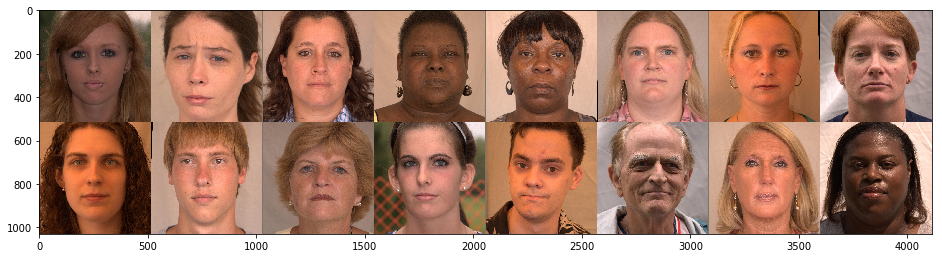

In [13]:
# clf_dataset = ClassificationDataset(ROOT, views, transform=transform_base, keypoints=False)
clf_dataset = ClassificationDataset(ROOT, views, transform=transform_kp, keypoints=True)
clf_loader = DataLoader(clf_dataset, batch_size=16, shuffle=True)

batch = next(iter(clf_loader))
grid = make_grid(batch['image'])

plt.figure(figsize=(16, 8))

plt.imshow(grid.numpy().transpose(1,2,0)*std + mean)

In [14]:
batch['label'], batch['keypoints'].shape

(tensor([147, 331, 236, 431, 334, 256, 223,  60,  16, 321, 283,  42,   5,  61,
         327, 134]), torch.Size([16, 68, 2]))